In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold




In [2]:
# Define the neural network class with batch normalization, dropouts and 
class MLPDOBNR(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_prob, l1_strength, l2_strength):
        super(MLPDOBNR, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.l1_strength = l1_strength
        self.l2_strength = l2_strength


    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

In [3]:
# Define the neural network class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

In [4]:
# Hyperparameters
input_size = 28 * 28  # Fashion MNIST image size
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10
dropout_prob = 0.5
l1_strength = 0.001  # Adjust the strength
l2_strength = 0.001  # Adjust the strength
num_splits = 5

In [5]:
data = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

In [6]:
X_train = data.iloc[:, 1:].values.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
y_train = data.iloc[:, 0].values
X_test = data.iloc[:, 1:].values.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
y_test = data.iloc[:, 0].values

In [7]:
class FashionMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader objects for training and testing data.
train_dataset = FashionMNISTDataset(X_train, y_train)
test_dataset = FashionMNISTDataset(X_test, y_test)

In [8]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
#model = MLPDOBNR(input_size, 128, 64, num_classes, dropout_prob, l1_strength, l2_strength)
model = MLP(input_size, 128, 64, num_classes)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
# Initialize lists to store training and test loss, training and test accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


In [16]:

for epoch in range(num_epochs):
    model.train()
    total_loss_train = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Regularization
        l1_reg = 0
        for param in model.parameters():
            l1_reg += torch.abs(param).sum()
        l2_reg = 0
        for param in model.parameters():
            l2_reg += (param ** 2).sum()
        loss += l1_strength * l1_reg + l2_strength * l2_reg

        loss.backward()
        optimizer.step()
        total_loss_train += loss.item()

        # Calculate training accuracy
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    # Calculate and store training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    avg_loss_train = total_loss_train / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(avg_loss_train)

    model.eval()
    total_loss_test = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss_test += loss.item()

            # Calculate testing accuracy
            correct_test += (outputs.argmax(1) == labels).sum().item()
            total_test += labels.size(0)

    # Calculate and store testing accuracy and loss
    test_accuracy = 100 * correct_test / total_test
    avg_loss_test = total_loss_test / len(test_loader)
    test_accuracies.append(test_accuracy)
    test_losses.append(avg_loss_test)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {avg_loss_test:.4f}, Test Acc: {test_accuracy:.2f}%')


Epoch [1/10], Train Loss: 1.2733, Train Acc: 73.51%, Test Loss: 0.6198, Test Acc: 78.23%
Epoch [2/10], Train Loss: 0.9601, Train Acc: 79.84%, Test Loss: 0.5669, Test Acc: 80.65%
Epoch [3/10], Train Loss: 0.8946, Train Acc: 80.86%, Test Loss: 0.5545, Test Acc: 81.40%
Epoch [4/10], Train Loss: 0.8617, Train Acc: 81.66%, Test Loss: 0.5266, Test Acc: 81.76%
Epoch [5/10], Train Loss: 0.8371, Train Acc: 82.26%, Test Loss: 0.5316, Test Acc: 81.62%
Epoch [6/10], Train Loss: 0.8236, Train Acc: 82.54%, Test Loss: 0.5127, Test Acc: 82.31%
Epoch [7/10], Train Loss: 0.8103, Train Acc: 82.66%, Test Loss: 0.5091, Test Acc: 82.27%
Epoch [8/10], Train Loss: 0.8011, Train Acc: 82.72%, Test Loss: 0.4943, Test Acc: 82.74%
Epoch [9/10], Train Loss: 0.7937, Train Acc: 82.80%, Test Loss: 0.4811, Test Acc: 83.52%
Epoch [10/10], Train Loss: 0.7839, Train Acc: 83.09%, Test Loss: 0.4807, Test Acc: 83.85%


In [19]:

# Training the model
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(testloader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


NameError: name 'net' is not defined

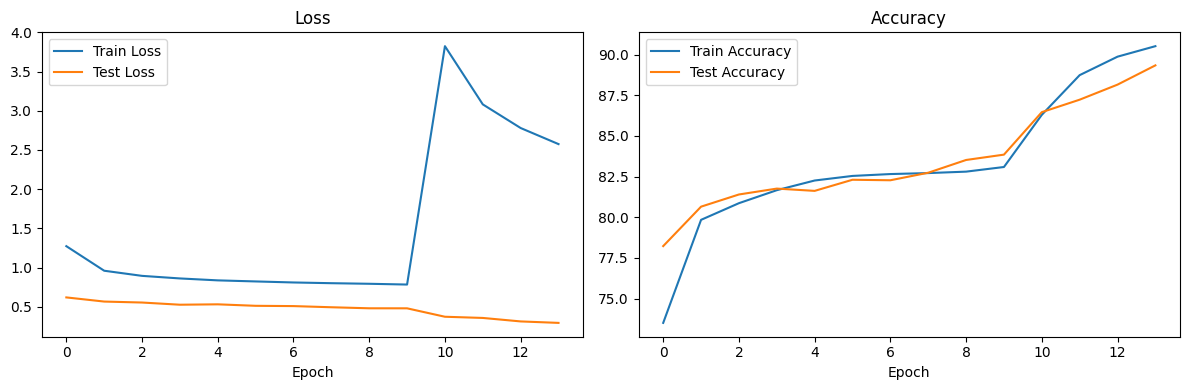

In [18]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
